# Library Import

In [1]:
import numpy as np
from scipy.optimize import least_squares, minimize
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error, r2_score)
import matplotlib.pyplot as plt

# Load Data

t: time  
f: failures  
cum_f: cumulative failures

In [2]:
data = np.loadtxt('J3.csv', delimiter=',', skiprows=1, dtype=int)
data = np.insert(data, 0, [0, 0, 0], axis=0)

In [3]:
t = data[:, 0]
f = data[:, 1]
cum_f = data[:, 2]

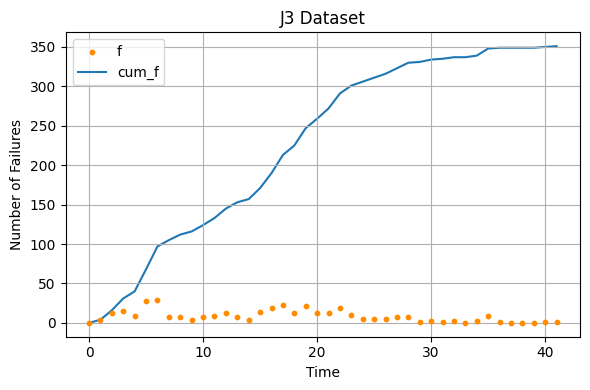

In [4]:
plt.figure(figsize=(6, 4))

plt.scatter(t, f, color='darkorange', s=10, label='f', zorder=2)
plt.plot(t, cum_f, label='cum_f', zorder=1)

plt.title('J3 Dataset')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

# Estimation

Preparation functions for parameter estimation

In [5]:
tiny = np.finfo(float).tiny  # Prevent log calculation errors (avoid log(0))


# Log-Logistic model function
def log_logistic(t, a, b, c):
    return a * (b * t)**c / (1 + (b * t)**c)


# Residual function for LSM estimation using Log-Logistic model
def log_logistic_lsm(params, t, cum_f):
    a, b, c = params
    return log_logistic(t, a, b, c) - cum_f


# Function to estimate parameter 'a' of the Log-Logistic model
def log_logistic_a(t, f, b, c):
    a = f * (1 + (b * t)**c) / (b * t)**c
    return a


# Negative log-likelihood function for the Log-Logistic model
def log_logistic_nll(params, t, f):
    b, c = params
    a = np.sum(f) * (1 + (b * t[-1])**c) / (b * t[-1])**c

    term1 = a * ((b * t[1:])**c / (1 + (b * t[1:])**c)
                 - (b * t[:-1])**c / (1 + (b * t[:-1])**c))
    term1[term1 < tiny] = tiny
    log_term1 = f[1:] * np.log(term1)

    term2 = a * ((b * t[-1])**c / (1 + (b * t[-1])**c)
                 - (b * t[0]**c) / (1 + (b * t[0])**c))

    log_facs = [np.sum([np.log(j) for j in range(1, i+1)]) for i in f[1:]]

    loglikelihood = np.sum(log_term1) - term2 - np.sum(log_facs)
    return -loglikelihood

Setup variables for parameter estimation

In [6]:
eps = np.sqrt(np.finfo(float).eps)  # Small epsilon to avoid division by zero

# Parameter initialization and bounds for LSM estimation
lsm_init_guess = [cum_f[-1] * 1.5, 0.1, 1]
lsm_bounds = ([cum_f[-1], eps, 0], [np.inf, np.inf, np.inf])

# Parameter initialization and bounds for MLE estimation
mle_init_guess = [0.1, 1]
mle_bounds = [(eps, np.inf), (0, np.inf)]

## LSM

### Trust Region Reflective algorithm

In [7]:
result = least_squares(log_logistic_lsm, lsm_init_guess, args=(t, cum_f),
                       method='trf', bounds=lsm_bounds)

trf_a, trf_b, trf_c = result.x
print(f'a: {trf_a}, b: {trf_b}, c: {trf_c}')

a: 460.3132651704542, b: 0.05681144850762876, c: 1.6399212262694682


In [8]:
f_pred = log_logistic(t, trf_a, trf_b, trf_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 203.98231166874618
RMSE: 14.282237628213101
MAE: 11.642685736968948
MAPE: 0.07426897281200086
R2 score: 0.9850336458644106


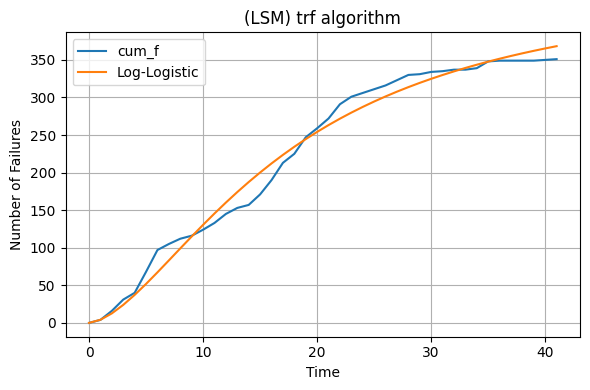

In [9]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(LSM) trf algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### dogleg algorithm

In [10]:
result = least_squares(log_logistic_lsm, lsm_init_guess, args=(t, cum_f),
                       method='dogbox', bounds=lsm_bounds)

dogbox_a, dogbox_b, dogbox_c = result.x
print(f'a: {dogbox_a}, b: {dogbox_b}, c: {dogbox_c}')

a: 460.31598032831937, b: 0.05681096286984818, c: 1.6399090678430583


In [11]:
f_pred = log_logistic(t, dogbox_a, dogbox_b, dogbox_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 203.98231167850784
RMSE: 14.282237628554842
MAE: 11.642704055959394
MAPE: 0.07426865259836722
R2 score: 0.9850336458636942


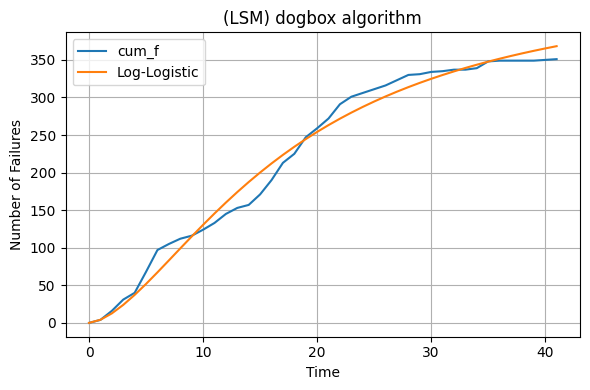

In [12]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(LSM) dogbox algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

## MLE

### Nelder-Mead algorithm

In [13]:
result = minimize(log_logistic_nll, mle_init_guess, args=(t, f),
                  method='Nelder-Mead', bounds=mle_bounds)

nelder_mead_b, nelder_mead_c = result.x
nelder_mead_a = log_logistic_a(t[-1], np.sum(f), nelder_mead_b, nelder_mead_c)
print(f'a: {nelder_mead_a}, b: {nelder_mead_b}, c: {nelder_mead_c}')

a: 422.0795719437086, b: 0.06428038125795861, c: 1.6479554276902495


In [14]:
f_pred = log_logistic(t, nelder_mead_a, nelder_mead_b, nelder_mead_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 277.0567991148208
RMSE: 16.64502325365816
MAE: 13.71206391908121
MAPE: 0.07890452886564381
R2 score: 0.9796721091289573


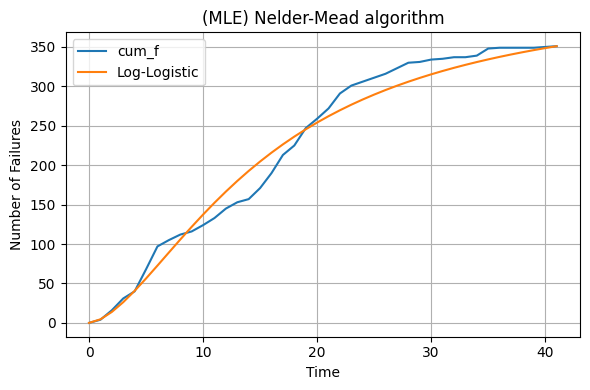

In [15]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(MLE) Nelder-Mead algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Powell algorithm

In [16]:
result = minimize(log_logistic_nll, mle_init_guess, args=(t, f),
                  method='Powell', bounds=mle_bounds)

powell_b, powell_c = result.x
powell_a = log_logistic_a(t[-1], np.sum(f), powell_b, powell_c)
print(f'a: {powell_a}, b: {powell_b}, c: {powell_c}')

a: 422.45728273624854, b: 0.06433090279864241, c: 1.6411559119797516


In [17]:
f_pred = log_logistic(t, powell_a, powell_b, powell_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 278.54890653426025
RMSE: 16.689784496339676
MAE: 13.724668484344456
MAPE: 0.07912554842259242
R2 score: 0.979562631949956


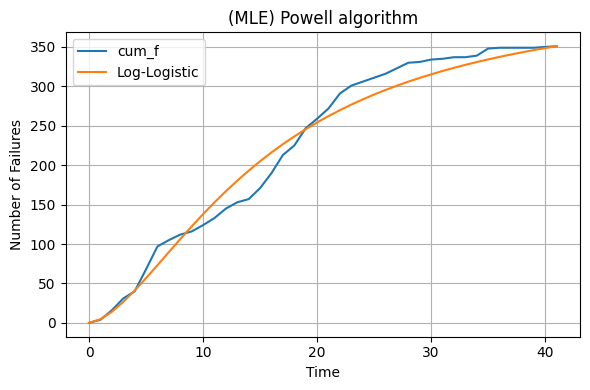

In [18]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(MLE) Powell algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### L-BFGS-B algorithm

In [19]:
result = minimize(log_logistic_nll, mle_init_guess, args=(t, f),
                  method='L-BFGS-B', bounds=mle_bounds)

l_bfgs_b_b, l_bfgs_b_c = result.x
l_bfgs_b_a = log_logistic_a(t[-1], np.sum(f), l_bfgs_b_b, l_bfgs_b_c)
print(f'a: {l_bfgs_b_a}, b: {l_bfgs_b_b}, c: {l_bfgs_b_c}')

a: 422.08516484798514, b: 0.06427920292816025, c: 1.6479054067751193


In [20]:
f_pred = log_logistic(t, l_bfgs_b_a, l_bfgs_b_b, l_bfgs_b_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 277.0640960499903
RMSE: 16.645242444914714
MAE: 13.712305380708488
MAPE: 0.0789056647177138
R2 score: 0.9796715737466737


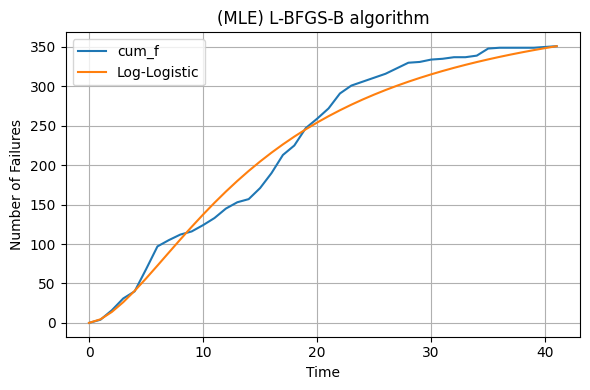

In [21]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(MLE) L-BFGS-B algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### truncated Newton (TNC) algorithm

In [22]:
result = minimize(log_logistic_nll, mle_init_guess, args=(t, f),
                  method='TNC', bounds=mle_bounds)

tnc_b, tnc_c = result.x
tnc_a = log_logistic_a(t[-1], np.sum(f), tnc_b, tnc_c)
print(f'a: {tnc_a}, b: {tnc_b}, c: {tnc_c}')

a: 422.08488875327276, b: 0.06427928255965923, c: 1.6479073081348106


In [23]:
f_pred = log_logistic(t, tnc_a, tnc_b, tnc_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 277.063888842699
RMSE: 16.645236220693864
MAE: 13.712292882445857
MAPE: 0.0789056322629903
R2 score: 0.9796715889496472


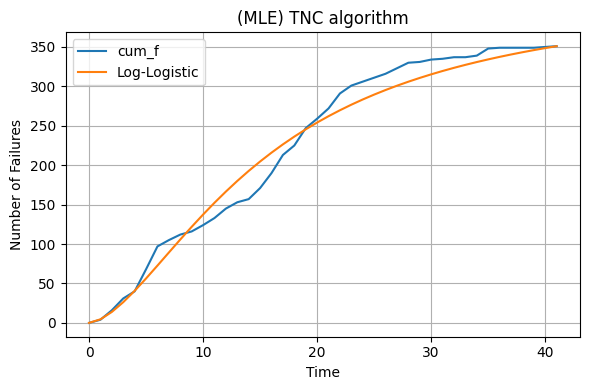

In [24]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(MLE) TNC algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Constrained Optimization BY Quadratic Approximations (COBYQA) algorithm

In [25]:
result = minimize(log_logistic_nll, mle_init_guess, args=(t, f),
                  method='COBYQA', bounds=mle_bounds)

cobyqa_b, cobyqa_c = result.x
cobyqa_a = log_logistic_a(t[-1], np.sum(f), cobyqa_b, cobyqa_c)
print(f'a: {cobyqa_a}, b: {cobyqa_b}, c: {cobyqa_c}')

a: 422.0850781881878, b: 0.06427924643390906, c: 1.6479055138448813


In [26]:
f_pred = log_logistic(t, cobyqa_a, cobyqa_b, cobyqa_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 277.0641630034665
RMSE: 16.645244456104166
MAE: 13.712300958380307
MAPE: 0.0789056749014468
R2 score: 0.9796715688342407


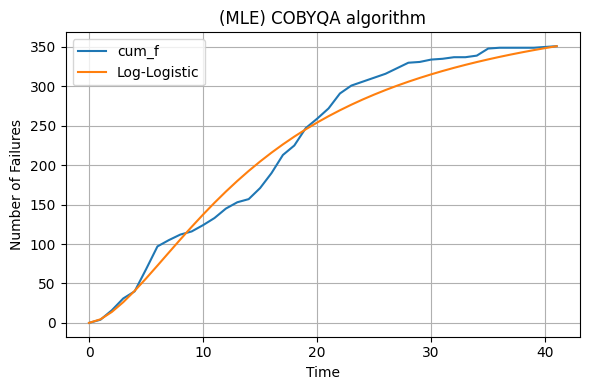

In [27]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(MLE) COBYQA algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Sequential Least Squares Programming (SLSQP)

In [28]:
result = minimize(log_logistic_nll, mle_init_guess, args=(t, f),
                  method='SLSQP', bounds=mle_bounds)

slsqp_b, slsqp_c = result.x
slsqp_a = log_logistic_a(t[-1], np.sum(f), slsqp_b, slsqp_c)
print(f'a: {slsqp_a}, b: {slsqp_b}, c: {slsqp_c}')

a: 422.08487936428224, b: 0.06427929952955688, c: 1.6479069954894607


/tmp/ipykernel_47764/4010908135.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  a = np.sum(f) * (1 + (b * t[-1])**c) / (b * t[-1])**c
/tmp/ipykernel_47764/4010908135.py:26: RuntimeWarning: invalid value encountered in multiply
  term1 = a * ((b * t[1:])**c / (1 + (b * t[1:])**c)
/tmp/ipykernel_47764/4010908135.py:31: RuntimeWarning: invalid value encountered in scalar multiply
  term2 = a * ((b * t[-1])**c / (1 + (b * t[-1])**c)


In [29]:
f_pred = log_logistic(t, slsqp_a, slsqp_b, slsqp_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 277.06398348980997
RMSE: 16.645239063762645
MAE: 13.712292072659439
MAPE: 0.07890564685365903
R2 score: 0.9796715820053089


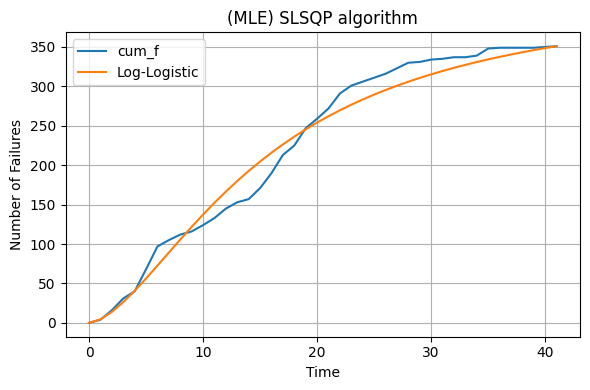

In [30]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(MLE) SLSQP algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Constrained Trust-Region algorithm

In [31]:
result = minimize(log_logistic_nll, mle_init_guess, args=(t, f),
                  method='trust-constr', bounds=mle_bounds)

trust_constr_b, trust_constr_c = result.x
trust_constr_a = log_logistic_a(t[-1], np.sum(f), trust_constr_b, trust_constr_c)
print(f'a: {trust_constr_a}, b: {trust_constr_b}, c: {trust_constr_c}')

a: 422.08511560866174, b: 0.06427922566308657, c: 1.6479055201156552


In [32]:
f_pred = log_logistic(t, trust_constr_a, trust_constr_b, trust_constr_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 277.06411994059414
RMSE: 16.645243162555307
MAE: 13.712302921524643
MAPE: 0.07890566832003452
R2 score: 0.9796715719938


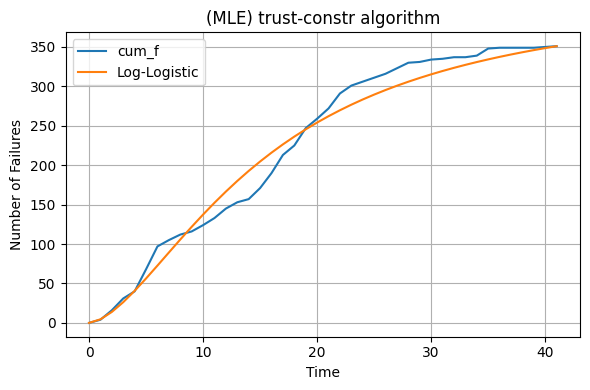

In [33]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(MLE) trust-constr algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()